In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime, timedelta
import yfinance as yf
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,GRU

In [25]:
VIX = yf.download('YUM',start='2000-01-01',end=datetime.now())

[*********************100%***********************]  1 of 1 completed


In [26]:
fig = px.line(VIX,x=VIX.index,y='Adj Close',title='Precio de cierre')
fig.show()

In [27]:
#Preparar los datos
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(VIX['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days,len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x,0])
  y_train.append(scaled_data[x,0])

x_train,y_train = np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

x_train.shape

(5783, 60, 1)

In [28]:
#Contruir el modelo
model = Sequential()

model.add(GRU(units=50,return_sequences = True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(GRU(units=50,return_sequences = True))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train,epochs=25,batch_size=32)

Epoch 1/25
181/181 [==============================] - 31s 103ms/step - loss: 0.0043
Epoch 2/25
181/181 [==============================] - 18s 98ms/step - loss: 0.0013
Epoch 3/25
181/181 [==============================] - 19s 103ms/step - loss: 9.8595e-04
Epoch 4/25
181/181 [==============================] - 16s 90ms/step - loss: 8.6773e-04
Epoch 5/25
181/181 [==============================] - 17s 93ms/step - loss: 7.9883e-04
Epoch 6/25
181/181 [==============================] - 17s 92ms/step - loss: 7.7658e-04
Epoch 7/25
181/181 [==============================] - 16s 87ms/step - loss: 8.3966e-04
Epoch 8/25
181/181 [==============================] - 16s 86ms/step - loss: 8.1530e-04
Epoch 9/25
181/181 [==============================] - 22s 124ms/step - loss: 8.0984e-04
Epoch 10/25
181/181 [==============================] - 26s 145ms/step - loss: 6.3191e-04
Epoch 11/25
181/181 [==============================] - 25s 141ms/step - loss: 6.5147e-04
Epoch 12/25
181/181 [=======================

In [35]:
#Cargar los datos del test
hist_test = yf.download('YUM',start='2000-01-01',end='2023-01-01')
actual_prices = hist_test["Close"].values

total_dataset = pd.concat((VIX['Close'],hist_test['Close']),axis=0)
model_inputs = total_dataset[len(total_dataset)-len(hist_test)-prediction_days:].values
model_inputs = scaler.transform(model_inputs.reshape(-1,1))

[*********************100%***********************]  1 of 1 completed


In [36]:
x_test = []

for x in range(prediction_days,len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

181/181 [==============================] - 5s 29ms/step


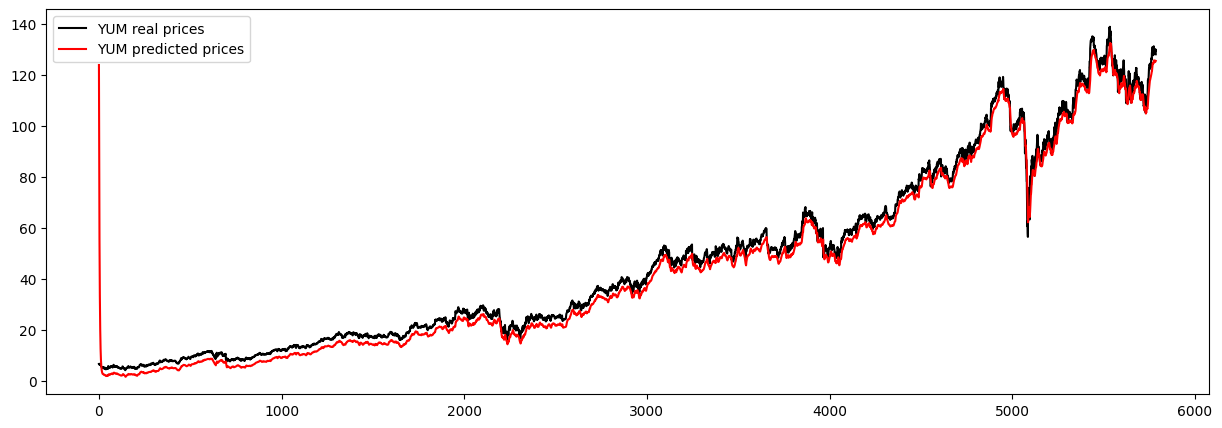

In [41]:
company = 'YUM'
plt.figure(figsize=(15,5))
plt.plot(actual_prices,color="black",label=f"{company} Precios reales")
plt.plot(predicted_prices,color="red",label=f"{company} Precios ")
plt.legend()
plt.show()

In [40]:
rentability = 1
for i in range(1,len(actual_prices)):
  if predicted_prices[i] > actual_prices[i-1]:
    rentability*= actual_prices[i]/actual_prices[i-1]

(rentability-1)*100,"%"

(-13.965700497803656, '%')